In [1]:
import numpy as np
import pandas as pd
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer


In [2]:
import pandas as pd
import numpy as np


file_path = "Datasets/VanilaDataset/PU results/"
trainDataset = pd.read_csv(file_path + 'train_PU_no_pattern_ohlc.csv', index_col=[0, 1])
testDataset = pd.read_csv(file_path + 'test_PU_no_pattern_ohlc.csv' , index_col=[0, 1])


In [3]:
# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Pattern'
series_length = 100  # Target series length for ROCKET

def adjust_series_length(group, target_length):

    series = group.values
    current_length = len(series)

    if current_length > target_length:
        return series[:target_length]
    else:
        # Padding with zeros if shorter
        padding = np.zeros((target_length - current_length, series.shape[1]))
        return np.vstack([series, padding])


def prepare_rocket_data(dataset, features, target, series_length):
    # Group by 'Instance' and adjust each series length
    adjusted = dataset.groupby(level=0).apply(
        lambda group: adjust_series_length(group[features], series_length)
    )
    
    # Stack adjusted arrays
    X = np.stack(adjusted.values)  # Shape: (num_samples, series_length, num_features)

    # Extract targets (one per instance)
    y = dataset.groupby(level=0)[target].first().values  # Shape: (num_samples,)
    
    X = np.transpose(X, (0, 2, 1)) # shape: (num_samples, num_features, series_length)

    return X, y

# Prepare training and testing data
X_train, y_train = prepare_rocket_data(trainDataset, features, target, series_length)
X_test, y_test = prepare_rocket_data(testDataset, features, target, series_length)

print(f"X_train shape: {X_train.shape}")  # Expect (7080, 5, 100)
print(f"y_train shape: {y_train.shape}")  # Expect (7080,)




X_train shape: (7306, 5, 100)
y_train shape: (7306,)


# Rocket With Logistic Regression


In [4]:
# from sktime.transformations.panel.rocket import Rocket
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sktime.datasets import load_unit_test  # Example dataset
# from sklearn.metrics import classification_report, accuracy_score

In [5]:
# rocket = Rocket(num_kernels=10000)
# clf = make_pipeline(rocket, LogisticRegression(max_iter=5000, multi_class='multinomial', solver='lbfgs'))


# print("Fitting the pipeline to the training dataset...")
# clf.fit(X_train, y_train)

In [6]:
# y_train_probs = clf.predict_proba(X_train)  # Training set probabilities
# y_test_probs = clf.predict_proba(X_test)

In [7]:
# y_test_probs

In [8]:
# y_train_probs

In [9]:
# from sklearn.metrics import accuracy_score

# # Training accuracy
# y_train_pred = y_train_probs.argmax(axis=1)  # Predicted classes for training data
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print(f"Training Accuracy: {train_accuracy:.2f}")

# # Testing accuracy
# y_test_pred = y_test_probs.argmax(axis=1)  # Predicted classes for test data
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Accuracy: {test_accuracy:.2f}")


In [10]:
model_stats = {}

# Rocket With XGBoost


In [ ]:
X_train = trainDataset.drop(columns=['Pattern'])
y_train = trainDataset.groupby(level=0)['Pattern'].first().to_frame()
X_test = testDataset.drop(columns=['Pattern'])
y_test = testDataset.groupby(level=0)['Pattern'].first().to_frame()

In [ ]:
y_train

In [ ]:
X_train

In [ ]:
# check X_train for inf values
print(X_train.isin([np.inf, -np.inf]).sum().sum())


In [ ]:
# check X_train for nan values
print(X_train.isna().sum().sum())

# check for nan values in each column
print(X_train.isna().sum())

# cjheck which rows have nan values
print(X_train[X_train.isna().any(axis=1)])

In [ ]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(method='ffill', inplace=True)

In [ ]:
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import make_pipeline
from utils.FixedLengthTransformer import FixedLengthTransformer
import time
from xgboost import XGBClassifier


fl = FixedLengthTransformer(fixed_length=100, fill_value=0)
rocket = Rocket(num_kernels=10000)
xgbr = XGBClassifier(
    eval_metric='mlogloss', 
    n_estimators=100,
    # device="cuda"
)

# record the time taken to fit the model
start = time.time()
clf_xgb = make_pipeline(
    fl,
    rocket,
    xgbr
)
clf_xgb.fit(X_train, y_train)

end = time.time()
time_rocket_xgb = end - start

model_stats['rocket_xgb_train_time'] = time_rocket_xgb

clf_xgb

In [ ]:
from xgboost import XGBClassifier
from sktime.transformations.panel.padder import PaddingTransformer

padder = PaddingTransformer(pad_length=100, fill_value=0)
rocket = Rocket(num_kernels=10000)


clf_xgb = make_pipeline(
    padder,
    rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
)
clf_xgb.fit(X_train, y_train)


In [ ]:
X_test

In [ ]:
import time
y_train_probs = clf_xgb.predict_proba(X_train) 
# record test time
start = time.time()
y_test_probs = clf_xgb.predict_proba(X_test)
end = time.time()
time_rocket_xgb_test = end - start
model_stats['rocket_xgb_test_time'] = time_rocket_xgb_test

In [ ]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)

model_stats['rocket_xgb_test_accuracy'] = test_accuracy

print(f"Test Accuracy: {test_accuracy:.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Get unique labels in sorted order
labels = np.unique(y_test)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# save the pipelined model
import joblib
joblib.dump(clf_xgb, "rocket_model_w_aug_PU.pkl")

In [ ]:
import os
import joblib

model_save_dir = ''
pipeline = joblib.load(os.path.join(model_save_dir, "rocket_model_w_aug.pkl"))
# predict on the subset of the test data

In [ ]:
y_pred_test = clf_xgb.predict_proba(X_test)
y_pred_test

In [ ]:
import numpy as np

def filter_predictions_with_threshold(y_pred_test, threshold):
    # Get the class with the maximum probability for each sample
    max_probs = np.max(y_pred_test, axis=1)  # Maximum probability for each sample
    max_classes = np.argmax(y_pred_test, axis=1)  # Corresponding class for max probability
    
    # Apply threshold condition
    results = np.where(max_probs >= threshold, max_classes, -1)
    
    return results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def filter_predictions_with_threshold(y_pred_test, threshold):
    # Get the max probability for each sample
    max_probs = np.max(y_pred_test, axis=1)
    max_classes = np.argmax(y_pred_test, axis=1)  # Class with max probability

    # Apply threshold condition
    results = np.where(max_probs >= threshold, max_classes, -1)
    
    # Plot a bar graph of max probabilities
    plot_max_probability_bar_graph(max_probs)
    
    return results

def plot_max_probability_bar_graph(max_probs):
    # Create bins for the probabilities (0.0 to 1.0 with a step of 0.1)
    bins = np.arange(0, 1.1, 0.1)
    
    # Plot the histogram
    plt.hist(max_probs, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Max Probability Distribution')
    plt.xlabel('Probability Bins (0.1 intervals)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(bins)  # Ensure bins align with ticks
    plt.show()

filter_predictions_with_threshold(y_pred_test, 0.5)

# Mini Rocket with XGBoost


[I 2025-03-13 16:15:42,759] A new study created in memory with name: xgboost_minirocket_optimization


Starting hyperparameter optimization...


[I 2025-03-13 16:17:53,814] Trial 0 finished with value: 0.6230737899476682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.010431936784236965, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 4, 'reg_alpha': 0.1929574155648097, 'reg_lambda': 0.19791875719153593, 'gamma': 0.1720892237937217, 'scale_pos_weight': 0.22303427543435778, 'max_delta_step': 1}. Best is trial 0 with value: 0.6230737899476682.
[I 2025-03-13 16:26:36,348] Trial 1 finished with value: 0.7092339261285909 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.049948579521342844, 'subsample': 0.8, 'colsample_bytree': 0.8500000000000001, 'min_child_weight': 2, 'reg_alpha': 0.00024647872583053826, 'reg_lambda': 0.7970337987523908, 'gamma': 0.0006310554596062322, 'scale_pos_weight': 6.3134245197716865, 'max_delta_step': 6}. Best is trial 1 with value: 0.7092339261285909.
[I 2025-03-13 16:35:27,050] Trial 2 finished with value: 0.6705694851361106 and

Optimization completed in 241.69 minutes
Best Parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.17554490579357612, 'subsample': 0.75, 'colsample_bytree': 0.7, 'min_child_weight': 9, 'reg_alpha': 0.34489165090165813, 'reg_lambda': 0.34386466836592605, 'gamma': 0.0003762180098445759, 'scale_pos_weight': 0.3301142672528994, 'max_delta_step': 5}
Best Score: 0.7394664842681259
Transforming data for final model...
Training final model...

Model Training Complete
Train Accuracy: 1.0000
Test Accuracy: 0.6821
Overfitting Gap: 0.3179
Generating optimization visualizations...


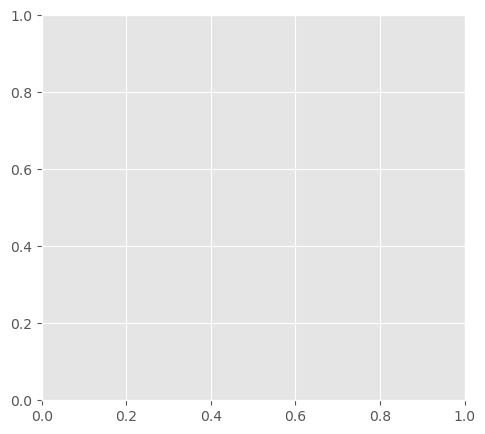

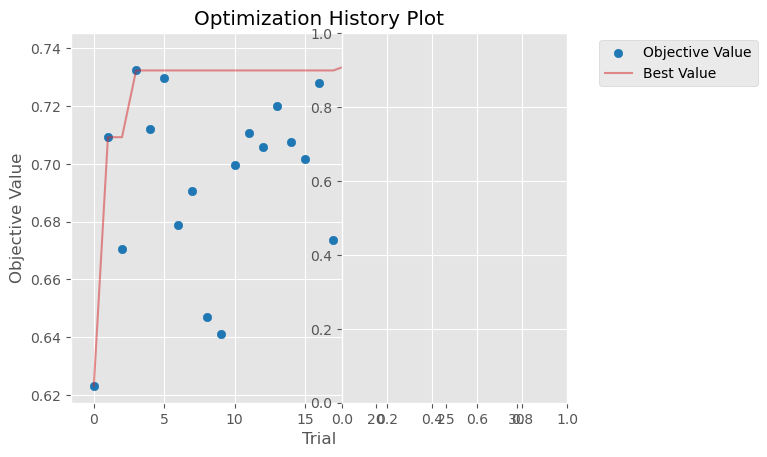

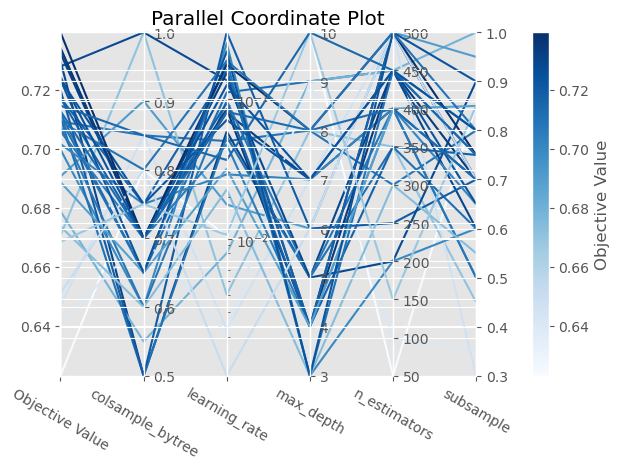

<Figure size 1000x600 with 0 Axes>

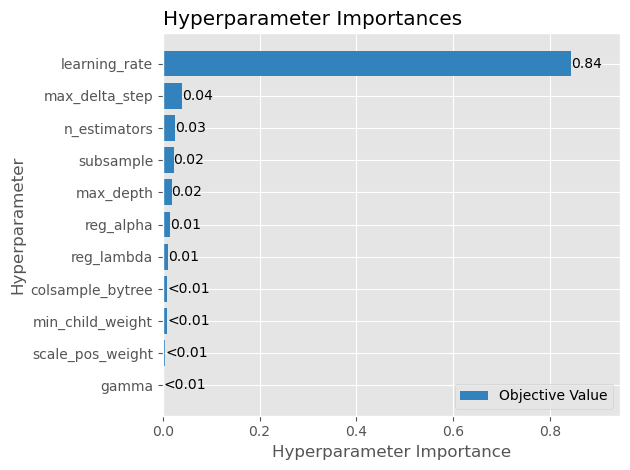

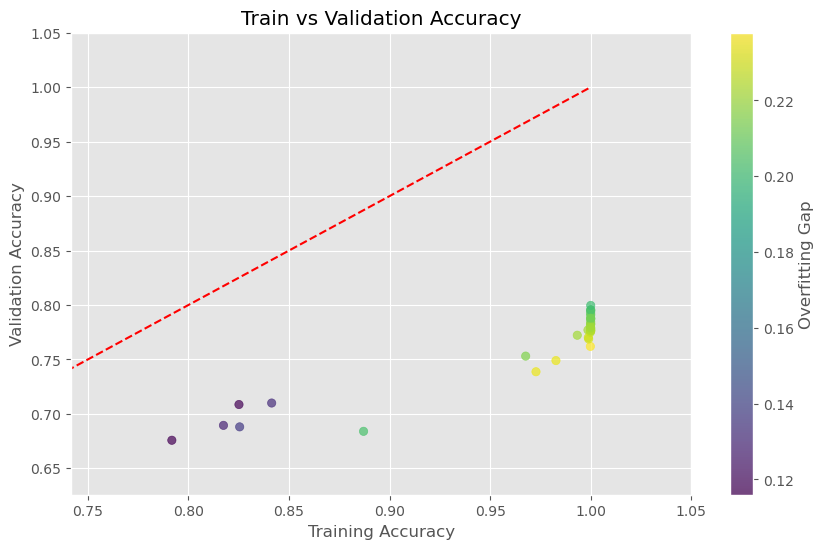

Evaluating final model...

Final Model Evaluation:
Accuracy: 0.6821
F1 Score: 0.6817
Precision: 0.6956
Recall: 0.6821


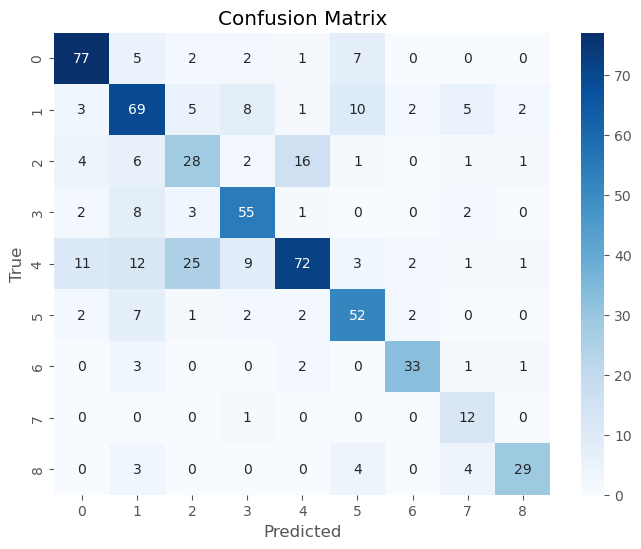

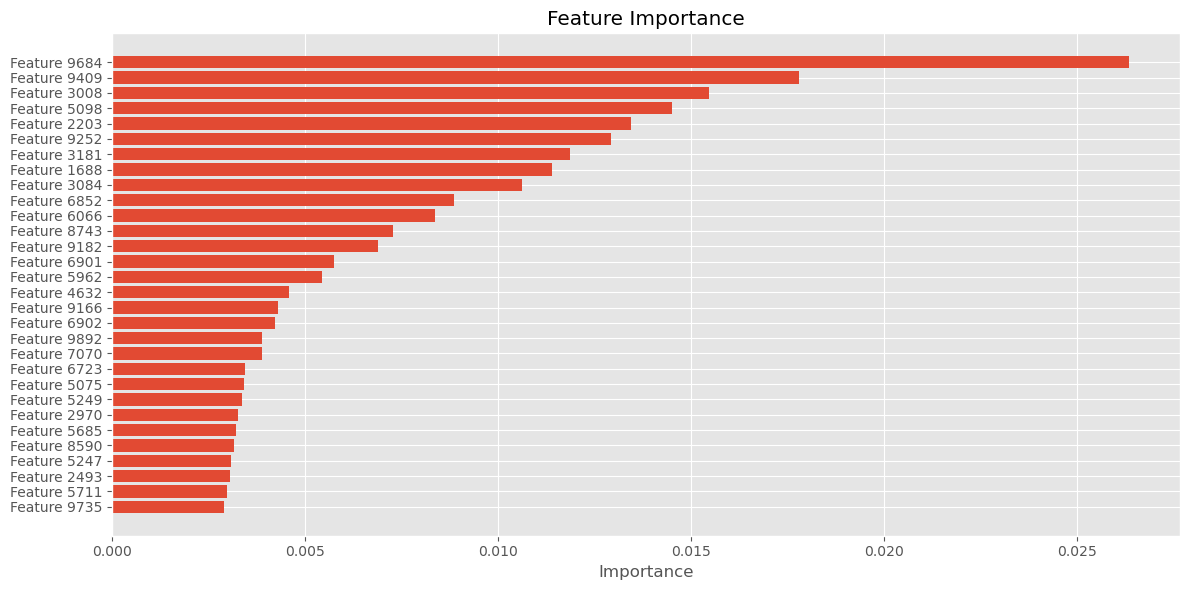

In [20]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from utils.FixedLengthTransformer import FixedLengthTransformer
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import optuna
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from time import time
import warnings
warnings.filterwarnings('ignore')

# Create a validation set to prevent information leakage during tuning
X_train_tuning, X_val, y_train_tuning, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Define transformers
fl = FixedLengthTransformer(fixed_length=100, fill_value=0)
mini_rocket = MiniRocketMultivariate(num_kernels=10000)

# Two-stage hyperparameter optimization using Optuna for more efficient search
def objective(trial):
    # XGBoost hyperparameters - broader search space with more fine-grained values
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.05),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1, log=True),
        'gamma': trial.suggest_float('gamma', 0.0001, 1, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0, log=True),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }
    
    # Create model
    xgb = XGBClassifier(
        **params,
        eval_metric='mlogloss',
        use_label_encoder=False,
        tree_method='hist',  # For faster training
        random_state=42
    )
    
    # Preprocess the data once to save computation time
    try:
        X_train_transformed = mini_rocket.fit_transform(fl.fit_transform(X_train_tuning))
        X_val_transformed = mini_rocket.transform(fl.transform(X_val))
    except Exception as e:
        print(f"Error during transformation: {e}")
        return float('-inf')
    
    # Simple model fitting without early stopping
    try:
        xgb.fit(X_train_transformed, y_train_tuning)
    except Exception as e:
        print(f"Error during model fitting: {e}")
        return float('-inf')
    
    # Calculate train and validation scores to monitor overfitting
    try:
        y_train_pred = xgb.predict(X_train_transformed)
        y_val_pred = xgb.predict(X_val_transformed)
        
        train_acc = accuracy_score(y_train_tuning, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        
        # Calculate overfitting penalty - we want to minimize the gap between train and val
        overfitting_gap = max(0, train_acc - val_acc)  # Ensure non-negative
        
        # Combine validation accuracy with overfitting penalty for optimization target
        # More weight on validation accuracy, but penalize overfitting
        score = val_acc - (0.3 * overfitting_gap)
        
        # Log metrics for later analysis
        trial.set_user_attr('train_accuracy', float(train_acc))
        trial.set_user_attr('val_accuracy', float(val_acc))
        trial.set_user_attr('overfitting_gap', float(overfitting_gap))
        
        return score
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return float('-inf')

# Create Optuna study
print("Starting hyperparameter optimization...")
start_time = time()

study = optuna.create_study(direction='maximize', study_name='xgboost_minirocket_optimization')
study.optimize(objective, n_trials=200, timeout=14400)  # 30 trials or max 4 hours

print(f"Optimization completed in {(time() - start_time)/60:.2f} minutes")

# Best parameters
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Create final model with best parameters and train on full training set
best_xgb = XGBClassifier(
    **best_params,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Process full data once for efficiency
print("Transforming data for final model...")
X_train_transformed = mini_rocket.fit_transform(fl.fit_transform(X_train))
X_test_transformed = mini_rocket.transform(fl.transform(X_test))

# Train final model on all training data
print("Training final model...")
best_xgb.fit(X_train_transformed, y_train)

# Create final pipeline for saving
final_pipeline = make_pipeline(fl, mini_rocket, best_xgb)

# Print info about the best model
print("\nModel Training Complete")
train_acc = accuracy_score(y_train, best_xgb.predict(X_train_transformed))
test_acc = accuracy_score(y_test, best_xgb.predict(X_test_transformed))
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Overfitting Gap: {max(0, train_acc - test_acc):.4f}")

# Visualization of hyperparameter optimization process
def plot_optimization_history():
    try:
        # Optimization history
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.subplot(1, 2, 2)
        try:
            optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=list(best_params.keys())[:5])
        except:
            print("Skipping parallel coordinate plot due to error")
        plt.tight_layout()
        plt.show()
        
        # Importance of hyperparameters
        plt.figure(figsize=(10, 6))
        try:
            optuna.visualization.matplotlib.plot_param_importances(study)
        except:
            print("Skipping parameter importance plot due to error")
        plt.tight_layout()
        plt.show()
        
        # Train vs Validation accuracy for all trials
        plt.figure(figsize=(10, 6))
        train_accuracies = [trial.user_attrs.get('train_accuracy', None) for trial in study.trials 
                           if 'train_accuracy' in trial.user_attrs]
        val_accuracies = [trial.user_attrs.get('val_accuracy', None) for trial in study.trials 
                         if 'val_accuracy' in trial.user_attrs]
        gaps = [trial.user_attrs.get('overfitting_gap', None) for trial in study.trials 
               if 'overfitting_gap' in trial.user_attrs]
        
        if train_accuracies and val_accuracies and gaps:
            plt.scatter(train_accuracies, val_accuracies, c=gaps, cmap='viridis', alpha=0.7)
            plt.colorbar(label='Overfitting Gap')
            plt.plot([0, 1], [0, 1], 'r--')
            plt.xlabel('Training Accuracy')
            plt.ylabel('Validation Accuracy')
            plt.title('Train vs Validation Accuracy')
            plt.xlim(min(train_accuracies)-0.05, 1.05)
            plt.ylim(min(val_accuracies)-0.05, 1.05)
            plt.grid(True)
            plt.show()
    except Exception as e:
        print(f"Error during visualization: {e}")

# Plot optimization history visualizations
print("Generating optimization visualizations...")
plot_optimization_history()

# Evaluate final model
def evaluate_final_model(model, X_test, y_test):
    try:
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        
        print("\nFinal Model Evaluation:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        
        # Confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Feature importance if available
        if hasattr(model, 'feature_importances_'):
            plt.figure(figsize=(12, 6))
            feature_importance = model.feature_importances_
            # Only show top 30 features if there are many
            if len(feature_importance) > 30:
                top_indices = np.argsort(feature_importance)[-30:]
                plt.barh(range(30), feature_importance[top_indices])
                plt.yticks(range(30), [f"Feature {i}" for i in top_indices])
            else:
                plt.barh(range(len(feature_importance)), feature_importance)
                plt.yticks(range(len(feature_importance)), [f"Feature {i}" for i in range(len(feature_importance))])
            plt.xlabel('Importance')
            plt.title('Feature Importance')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error during final evaluation: {e}")

# Evaluate the final model
print("Evaluating final model...")
evaluate_final_model(best_xgb, X_test_transformed, y_test)



In [21]:
# Additional analysis for reducing overfitting
print("\nAdditional Analysis for Reducing Overfitting:")

# 1. Feature importance-based feature selection
if hasattr(best_xgb, 'feature_importances_'):
    # Get feature importances
    importances = best_xgb.feature_importances_
    
    # Test models with different feature count thresholds
    thresholds = [0.001, 0.005, 0.01]
    print("\nTesting feature selection thresholds:")
    
    for threshold in thresholds:
        # Select features above threshold
        mask = importances > threshold
        selected_features_count = np.sum(mask)
        
        if selected_features_count > 0:
            # Train a model using only important features
            # Convert to numpy array if it's a DataFrame
            if isinstance(X_train_transformed, pd.DataFrame):
                X_train_selected = X_train_transformed.values[:, mask]
                X_test_selected = X_test_transformed.values[:, mask]
            else:
                X_train_selected = X_train_transformed[:, mask]
                X_test_selected = X_test_transformed[:, mask]
            
            # Create a simpler model with reduced regularization
            reduced_model = XGBClassifier(
                n_estimators=best_params['n_estimators'],
                max_depth=best_params['max_depth'],
                learning_rate=best_params['learning_rate'],
                random_state=42
            )
            
            reduced_model.fit(X_train_selected, y_train)
            
            # Evaluate
            train_acc = accuracy_score(y_train, reduced_model.predict(X_train_selected))
            test_acc = accuracy_score(y_test, reduced_model.predict(X_test_selected))
            
            print(f"Threshold {threshold}: {selected_features_count} features selected")
            print(f"  Train accuracy: {train_acc:.4f}")
            print(f"  Test accuracy: {test_acc:.4f}")
            print(f"  Overfitting gap: {max(0, train_acc - test_acc):.4f}")
        else:
            print(f"Threshold {threshold}: No features selected")
# 2. Test different max_depth values with the best model
print("\nTesting different tree depths:")
depths = [3, 4, 5, 6, 7]
for depth in depths:
    # Create a model with a different depth
    test_model = XGBClassifier(
        **{k: v for k, v in best_params.items() if k != 'max_depth'},
        max_depth=depth,
        random_state=42
    )
    
    test_model.fit(X_train_transformed, y_train)
    
    train_acc = accuracy_score(y_train, test_model.predict(X_train_transformed))
    test_acc = accuracy_score(y_test, test_model.predict(X_test_transformed))
    
    print(f"max_depth={depth}:")
    print(f"  Train accuracy: {train_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")
    print(f"  Overfitting gap: {max(0, train_acc - test_acc):.4f}")

# 3. Ensemble of models with different hyperparameters
print("\nCreating ensemble of top models:")
try:
    # Get top 5 trials
    top_trials = sorted(study.trials, key=lambda t: t.value if t.value != float('-inf') else float('-inf'))[-5:]
    
    if len(top_trials) > 1:
        ensemble_models = []
        
        for i, trial in enumerate(top_trials):
            if trial.state == optuna.trial.TrialState.COMPLETE and trial.value != float('-inf'):
                model_params = trial.params
                model = XGBClassifier(**model_params, random_state=42)
                model.fit(X_train_transformed, y_train)
                ensemble_models.append(model)
                print(f"Added model {i+1} with params: {model_params}")
        
        if ensemble_models:
            # Make predictions with ensemble
            ensemble_preds = np.array([model.predict(X_test_transformed) for model in ensemble_models])
            final_preds = np.apply_along_axis(
                lambda x: np.bincount(x).argmax(), 
                axis=0, 
                arr=ensemble_preds
            )
            
            # Evaluate ensemble
            ensemble_acc = accuracy_score(y_test, final_preds)
            print(f"Ensemble test accuracy: {ensemble_acc:.4f}")
            print(f"Best single model test accuracy: {test_acc:.4f}")
            
            if ensemble_acc > test_acc:
                print("Ensemble performs better than best single model!")
            else:
                print("Best single model performs better than ensemble.")
        else:
            print("No valid models for ensemble")
    else:
        print("Not enough valid trials for ensemble")
except Exception as e:
    print(f"Error creating ensemble: {e}")




Additional Analysis for Reducing Overfitting:

Testing feature selection thresholds:
Threshold 0.001: 115 features selected
  Train accuracy: 1.0000
  Test accuracy: 0.6278
  Overfitting gap: 0.3722
Threshold 0.005: 15 features selected
  Train accuracy: 0.9989
  Test accuracy: 0.5000
  Overfitting gap: 0.4989
Threshold 0.01: 9 features selected
  Train accuracy: 0.9878
  Test accuracy: 0.4233
  Overfitting gap: 0.5645

Testing different tree depths:
max_depth=3:
  Train accuracy: 1.0000
  Test accuracy: 0.6933
  Overfitting gap: 0.3067
max_depth=4:
  Train accuracy: 1.0000
  Test accuracy: 0.6773
  Overfitting gap: 0.3227
max_depth=5:
  Train accuracy: 1.0000
  Test accuracy: 0.6981
  Overfitting gap: 0.3019
max_depth=6:
  Train accuracy: 1.0000
  Test accuracy: 0.6805
  Overfitting gap: 0.3195
max_depth=7:
  Train accuracy: 1.0000
  Test accuracy: 0.6757
  Overfitting gap: 0.3243

Creating ensemble of top models:
Added model 1 with params: {'n_estimators': 450, 'max_depth': 5, 'lear

In [24]:
best_params

{'n_estimators': 500,
 'max_depth': 8,
 'learning_rate': 0.17554490579357612,
 'subsample': 0.75,
 'colsample_bytree': 0.7,
 'min_child_weight': 9,
 'reg_alpha': 0.34489165090165813,
 'reg_lambda': 0.34386466836592605,
 'gamma': 0.0003762180098445759,
 'scale_pos_weight': 0.3301142672528994,
 'max_delta_step': 5}

In [22]:
# Save best model and results
try:
    import joblib
    print("\nSaving model and results...")
    joblib.dump(final_pipeline, 'best_minirocket_xgb_model.pkl')
    
    # Save hyperparameter optimization results
    valid_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value != float('-inf')]
    if valid_trials:
        optimization_results = pd.DataFrame({
            'trial': [t.number for t in valid_trials],
            'value': [t.value for t in valid_trials],
            'train_accuracy': [t.user_attrs.get('train_accuracy', None) for t in valid_trials],
            'val_accuracy': [t.user_attrs.get('val_accuracy', None) for t in valid_trials],
            'overfitting_gap': [t.user_attrs.get('overfitting_gap', None) for t in valid_trials],
            **{f'params_{k}': [t.params.get(k, None) for t in valid_trials] for k in best_params.keys()}
        })
        
        optimization_results.to_csv('hyperparameter_optimization_results.csv', index=False)
        print("Results saved to 'hyperparameter_optimization_results.csv'")
    else:
        print("No valid trials to save")
except Exception as e:
    print(f"Error saving results: {e}")

print("Hyperparameter tuning process complete!")


Saving model and results...
Results saved to 'hyperparameter_optimization_results.csv'
Hyperparameter tuning process complete!


In [19]:
optimization_results

,trial,value,train_accuracy,val_accuracy,overfitting_gap,params_n_estimators,params_max_depth,params_learning_rate,params_subsample,params_colsample_bytree,params_min_child_weight,params_reg_alpha,params_reg_lambda,params_gamma,params_scale_pos_weight,params_max_delta_step
0,0,0.702120,1.000000,0.770862,0.229138,250,3,0.201314,0.65,0.95,1,0.010356,0.207789,0.000219,0.982194,3
1,1,0.713561,0.997433,0.779070,0.218363,400,8,0.021569,0.95,0.80,10,0.047882,0.604886,0.116580,0.122197,3
2,2,0.704788,1.000000,0.772914,0.227086,200,4,0.151694,1.00,0.70,1,0.008271,2.063175,0.000778,0.123142,9
3,3,0.651267,0.739733,0.671683,0.068050,150,4,0.008344,0.55,0.90,7,0.000213,0.241478,1.163404,0.139067,9
4,4,0.658981,0.817762,0.695622,0.122139,250,5,0.007866,0.65,1.00,3,0.551626,3.826100,0.276665,2.826076,7
5,5,0.667984,0.938912,0.730506,0.208406,50,7,0.084314,0.60,0.50,7,0.102138,0.167855,0.000815,0.521407,4
6,6,0.702326,0.999316,0.770862,0.228454,100,6,0.247466,0.55,0.85,4,2.416914,3.824427,0.003192,0.443004,7
7,7,0.659366,0.940965,0.724350,0.216615,50,5,0.167747,0.75,0.60,3,0.000422,1.360219,2.413319,5.244546,6
8,8,0.687945,0.999829,0.759918,0.239911,150,4,0.206092,0.75,0.55,7,0.000158,0.315923,0.018956,1.158119,6
9,9,0.657463,0.882101,0.709302,0.172799,100,5,0.034919,0.80,0.65,5,0.000284,0.442372,0.007036,3.379902,5


Fitting 3 folds for each of 20 candidates, totalling 60 fits


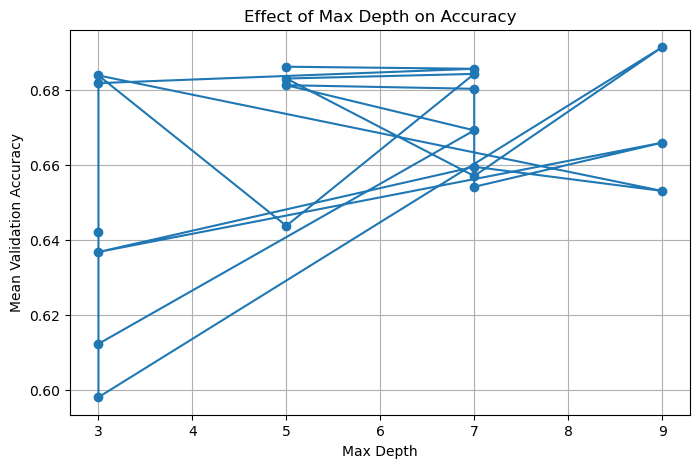

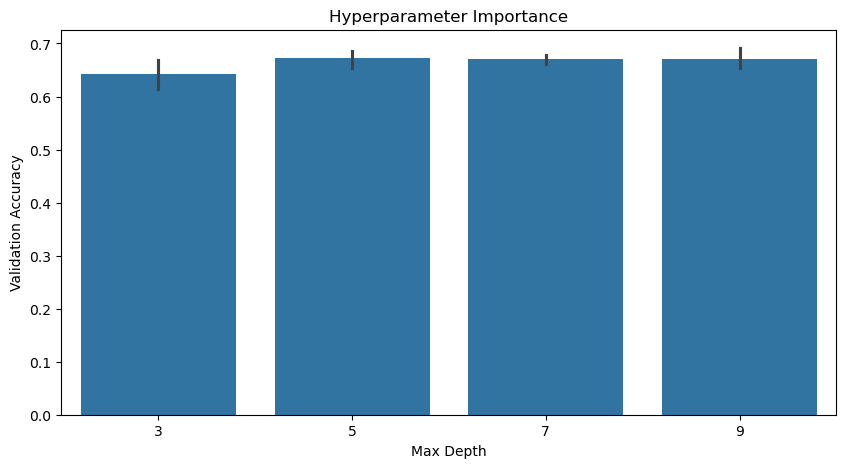

C:\Users\gwiku\AppData\Local\Temp\ipykernel_37520\197336550.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_params['mean_test_score'] = (df_params['mean_test_score'] - df_params['mean_test_score'].min()) / (df_params['mean_test_score'].max() - df_params['mean_test_score'].min())


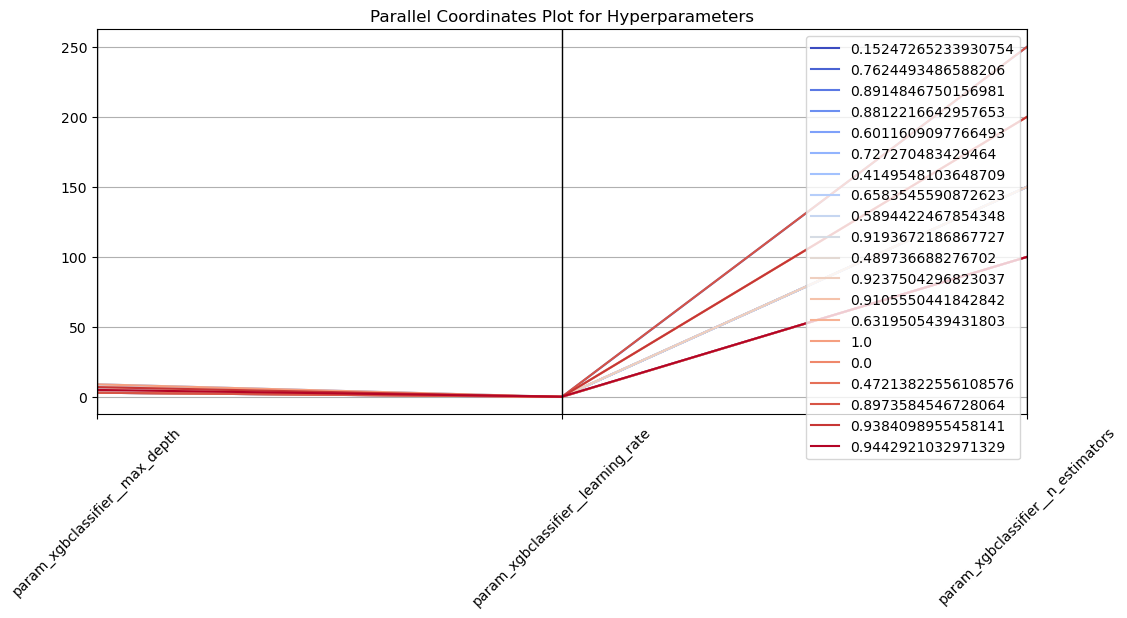

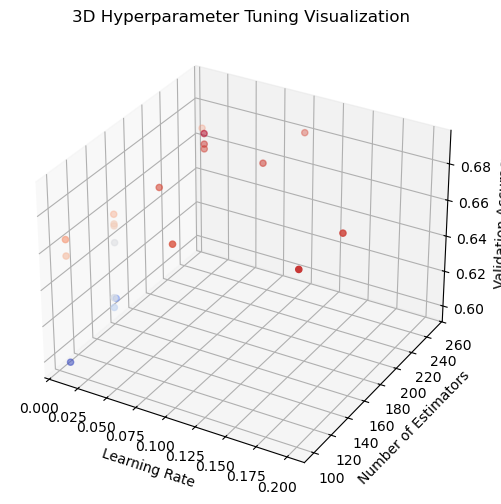

ValueError: Index contains duplicate entries, cannot reshape

In [12]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from utils.FixedLengthTransformer import FixedLengthTransformer
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D

# Define transformers and model
mini_rocket = MiniRocketMultivariate(num_kernels=5000)
fl = FixedLengthTransformer(fixed_length=100, fill_value=0)
xgb_mr = XGBClassifier(eval_metric='mlogloss')

# Hyperparameter grid
param_grid = {
    'xgbclassifier__n_estimators': [100, 150, 200, 250],
    'xgbclassifier__max_depth': [3, 5, 7, 9],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbclassifier__min_child_weight': [1, 3, 5],
    'xgbclassifier__reg_alpha': [0.0, 0.1, 0.5],
    'xgbclassifier__reg_lambda': [0.5, 0.6, 1.0],
    'xgbclassifier__gamma': [0, 0.1, 0.2]
}

# Pipeline
clf_mini_rocket_xgb = make_pipeline(fl, mini_rocket, xgb_mr)

# Hyperparameter tuning
random_search = RandomizedSearchCV(
    clf_mini_rocket_xgb, param_grid, n_iter=20, scoring='accuracy', n_jobs=8, cv=3, verbose=1, random_state=42
)

random_search.fit(X_train, y_train)

# Extract results
results = pd.DataFrame(random_search.cv_results_)


# Print best parameters
print("Best Parameters:", random_search.best_params_)

# Visualization 1: Validation Score vs. Each Hyperparameter
plt.figure(figsize=(8, 5))
plt.plot(results['param_xgbclassifier__max_depth'], results['mean_test_score'], 'o-')
plt.xlabel("Max Depth")
plt.ylabel("Mean Validation Accuracy")
plt.title("Effect of Max Depth on Accuracy")
plt.grid()
plt.show()

# Visualization 2: Hyperparameter Importance
importance = results[['param_xgbclassifier__max_depth', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=importance['param_xgbclassifier__max_depth'], y=importance['mean_test_score'])
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Importance")
plt.show()

# Visualization 3: Parallel Coordinates Plot
params = ['param_xgbclassifier__max_depth', 'param_xgbclassifier__learning_rate', 'param_xgbclassifier__n_estimators', 'mean_test_score']
df_params = results[params]
df_params['mean_test_score'] = (df_params['mean_test_score'] - df_params['mean_test_score'].min()) / (df_params['mean_test_score'].max() - df_params['mean_test_score'].min())
plt.figure(figsize=(12, 5))
parallel_coordinates(df_params, 'mean_test_score', colormap=plt.get_cmap("coolwarm"))
plt.title("Parallel Coordinates Plot for Hyperparameters")
plt.xticks(rotation=45)
plt.show()

# Visualization 4: 3D Hyperparameter Surface Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results["param_xgbclassifier__learning_rate"], results["param_xgbclassifier__n_estimators"], results["mean_test_score"], c=results["mean_test_score"], cmap="coolwarm")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Number of Estimators")
ax.set_zlabel("Validation Accuracy")
ax.set_title("3D Hyperparameter Tuning Visualization")
plt.show()


# Print best parameters
print("Best Parameters:", random_search.best_params_)


In [19]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__subsample,param_xgbclassifier__reg_lambda,param_xgbclassifier__reg_alpha,param_xgbclassifier__n_estimators,param_xgbclassifier__min_child_weight,param_xgbclassifier__max_depth,param_xgbclassifier__learning_rate,param_xgbclassifier__gamma,param_xgbclassifier__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,240.737827,1.479658,10.545410,0.238571,0.6,0.5,0.0,150,5,3,0.01,0.0,0.8,"{'xgbclassifier__subsample': 0.6, 'xgbclassifi...",0.637521,0.614784,0.584394,0.612233,0.021764,19
1,847.157401,4.767997,11.869632,0.881559,1.0,0.6,0.5,250,3,7,0.01,0.0,0.6,"{'xgbclassifier__subsample': 1.0, 'xgbclassifi...",0.693760,0.665708,0.648049,0.669173,0.018822,10
2,355.476889,4.704047,11.628363,0.436824,0.8,1.0,0.0,150,5,5,0.05,0.1,1.0,"{'xgbclassifier__subsample': 0.8, 'xgbclassifi...",0.704433,0.671458,0.667762,0.681218,0.016485,8
3,343.677181,2.319984,12.088531,0.530540,1.0,0.5,0.5,100,1,7,0.10,0.2,1.0,"{'xgbclassifier__subsample': 1.0, 'xgbclassifi...",0.702791,0.682957,0.655031,0.680260,0.019591,9
4,484.420671,7.404345,11.969832,0.851982,0.8,1.0,0.5,150,5,7,0.01,0.2,0.6,"{'xgbclassifier__subsample': 0.8, 'xgbclassifi...",0.676519,0.648460,0.637372,0.654117,0.016475,14
5,434.613531,2.697931,12.201394,1.391243,0.8,0.5,0.0,100,3,9,0.01,0.1,0.6,"{'xgbclassifier__subsample': 0.8, 'xgbclassifi...",0.682266,0.670637,0.644764,0.665889,0.015674,11
6,186.968971,1.423800,11.171899,0.238468,1.0,0.5,0.0,100,1,3,0.05,0.0,0.8,"{'xgbclassifier__subsample': 1.0, 'xgbclassifi...",0.650657,0.637782,0.621766,0.636735,0.011818,18
7,485.607118,1.049441,10.912170,0.077616,0.6,1.0,0.1,150,5,7,0.01,0.1,1.0,"{'xgbclassifier__subsample': 0.6, 'xgbclassifi...",0.676108,0.656263,0.645996,0.659456,0.012499,12
8,622.772023,5.474982,12.408894,0.412835,1.0,0.5,0.1,150,5,9,0.01,0.1,0.8,"{'xgbclassifier__subsample': 1.0, 'xgbclassifi...",0.667488,0.647639,0.643943,0.653023,0.010339,15
9,344.030652,18.717348,12.555275,0.336386,0.8,0.6,0.1,200,1,3,0.10,0.2,1.0,"{'xgbclassifier__subsample': 0.8, 'xgbclassifi...",0.691297,0.691992,0.668172,0.683820,0.011068,5


In [13]:

# Print best parameters
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'xgbclassifier__subsample': 0.6, 'xgbclassifier__reg_lambda': 0.6, 'xgbclassifier__reg_alpha': 0.0, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 0, 'xgbclassifier__colsample_bytree': 0.6}


In [16]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from utils.FixedLengthTransformer import FixedLengthTransformer
import time
from xgboost import XGBClassifier

mini_rocket = MiniRocketMultivariate(num_kernels=5000)
fl = FixedLengthTransformer(fixed_length=100, fill_value=0)
xgb_mr = XGBClassifier(
        eval_metric='mlogloss',
        n_estimators=20,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.6,
        colsample_bytree=0.6,
        min_child_weight=3,
        reg_alpha=0.0,
        reg_lambda=0.6,
        gamma=0.0
    )

start = time.time()

clf_mini_rocket_xgb = make_pipeline(
    fl,
    mini_rocket,
    xgb_mr
)
clf_mini_rocket_xgb.fit(X_train, y_train)

end = time.time()
time_mini_rocket_xgb = end - start
model_stats['mini_rocket_xgb_train_time'] = time_mini_rocket_xgb
clf_mini_rocket_xgb

Pipeline(steps=[('fixedlengthtransformer',
                 FixedLengthTransformer(fixed_length=100)),
                ('minirocketmultivariate',
                 MiniRocketMultivariate(num_kernels=5000)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical...
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=20,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [17]:
y_train_probs = clf_mini_rocket_xgb.predict_proba(X_train) 
start = time.time()
y_test_probs = clf_mini_rocket_xgb.predict_proba(X_test)
end = time.time()
time_mini_rocket_xgb_test = end - start
model_stats['mini_rocket_xgb_test_time'] = time_mini_rocket_xgb_test

In [ ]:
y_test_probs

In [ ]:
# for loop to iterate over the y_test_probs
for i in range(0, len(y_test_probs)):
    print(y_test_probs[i][7])

In [ ]:
y_test_pred

In [ ]:
y_test

In [18]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

model_stats['mini_rocket_xgb_test_accuracy'] = test_accuracy

Training Accuracy: 0.93
Test Accuracy: 0.63


In [ ]:
# save the pipelined model
import joblib
joblib.dump(clf_mini_rocket_xgb, "mini_rocket_model_w_aug_PU.pkl")


# MultiRocket XGBoost


In [ ]:
from sktime.transformations.panel.rocket import MultiRocketMultivariate
from xgboost import XGBClassifier

multi_rocket = MultiRocketMultivariate(num_kernels=10000)
start = time.time()
clf_multi_rocket_xgb = make_pipeline(
    fl,
    multi_rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
)
clf_multi_rocket_xgb.fit(X_train, y_train)
end = time.time()
time_multi_rocket_xgb = end - start
model_stats['multi_rocket_xgb_train_time'] = time_multi_rocket_xgb
clf_multi_rocket_xgb

In [ ]:
X_test

In [ ]:
y_train_probs = clf_multi_rocket_xgb.predict_proba(X_train) 
start = time.time()
y_test_probs = clf_multi_rocket_xgb.predict_proba(X_test)
end = time.time()
time_multi_rocket_xgb_test = end - start
model_stats['multi_rocket_xgb_test_time'] = time_multi_rocket_xgb_test

In [ ]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

model_stats['multi_rocket_xgb_test_accuracy'] = test_accuracy

In [ ]:
# save the pipelined model
import joblib
joblib.dump(clf_multi_rocket_xgb, "multi_rocket_model_w_aug_PU.pkl")


In [ ]:
model_stats

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Extract categories
models = ['Rocket XGB', 'Mini Rocket XGB', 'Multi Rocket XGB']

# Organizing data
train_times = [model_stats['rocket_xgb_train_time'], model_stats['mini_rocket_xgb_train_time'], model_stats['multi_rocket_xgb_train_time']]
test_times = [model_stats['rocket_xgb_test_time'], model_stats['mini_rocket_xgb_test_time'], model_stats['multi_rocket_xgb_test_time']]
accuracies = [model_stats['rocket_xgb_test_accuracy'], model_stats['mini_rocket_xgb_test_accuracy'], model_stats['multi_rocket_xgb_test_accuracy']]

# Plotting Train Time
plt.figure(figsize=(8, 5))
plt.bar(models, train_times, color='b')
plt.xlabel('Models')
plt.ylabel('Train Time')
plt.title('Training Time Comparison')
plt.show()

# Plotting Test Time
plt.figure(figsize=(8, 5))
plt.bar(models, test_times, color='g')
plt.xlabel('Models')
plt.ylabel('Test Time')
plt.title('Testing Time Comparison')
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color='r')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

In [ ]:
#  draw a bar graph of every models accuracy
import matplotlib.pyplot as plt

models = ['Rocket_with_logistic_regression', 'Rocket_with_XGBoost', 'MiniRocket_with_XGBoost', 'MultiRocket_with_XGBoost']

accuracies = [0.79,  0.83,0.78, 0.80]

plt.bar(models, accuracies, color='blue', alpha=0.7, edgecolor='black')
plt.title('Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()